# Présentation du notebook

## Objectifs

Ce notebook est destiné à explorer l'utilité d'une étape d'oversampling dans notre pipeline basé sur **XGBoost**. Il complète le notebook de modélisation nommé `ML_stats`. \
L'idée n'est pas de relancer l'exploration de toutes les étapes du pipeline basé sur XGBoost, mais seulement de tester si, avec les meilleurs paramètres identifiés précédemment, l'ajout d'une étape d'oversampling peut améliorer les performances du pipeline.

## Utilisation

Dans la partie **Configuration** ci-dessous :
- activer ou non MLflow
  - si vous choisissez d'activer MLflow, indiquer l'URI d'un serveur existant ou bien démarrer un serveur local tel qu'indiqué ci-après
- activer ou non le préchargement des modules

## Methodologie

Rien d'original : on se sert de la structure utilisée précédemment dans le notebook `ML_stats`, et de la recherche des meilleurs paramètres par **GridSearch** pour trouver la meilleure approche d'oversampling de notre jeu de données, et vérifier si cela améliore les performances du pipeline en termes d'**accuracy**, de **f1_score macro**, et de **précision** et **rappel** sur les classes minoritaires ainsi que la classe **healthy**.

# Configuration

Ci-dessous on définit le fichier permettant de charger notre jeu de données. Ce fichier a été généré par le notebook `Data Exploration`.

In [1]:
PVF10_CSVFILE = "../data/processed/structure_pvf_10.csv"

Ensuite on définit quelques variables globales permettant de choisir ce qu'on souhaite exécuter ou non dans le notebook.

**Note concernant MLflow :**

Pour un tel notebook de travail, destiné à être utilisé en commentant/décommentant certaines sections ou certains paramètres, en exécutant certaines parties de nombreuses fois tout au long du processus d'exploration, MLflow permet de logger de façon très efficace et très rigoureuse l'ensemble des paramètres de configuraion et des métriques obtenus sur chacun des pipelines évalués. Quand le nombre de pipelines atteint plusieurs dizaines, un outil tel que MLflow s'avère très précieux (voire indispensable) pour comparer facilement les pipelines les uns aux autres et déterminer les meilleurs paramètres, quelles que soient les critères choisis (scores et temps de calcul notamment).

Si l'on ne dispose pas d'un serveur MLflow distant, il est très simple d'en mettre un en place localement.

Etapes à suivre :

1. Créer et se placer dans un répertoire qui servira à stocker les logs des runs et leurs artefacts
1. Créer les répertoires locaux `mlruns`et `mlartifacts`
    ``` shell
    $ mkdir mlruns mlartifacts

    ```
1. Activer l'environnement python du projet et exécuter la commande suivante :
    ``` shell
    $ mlflow server --host 0.0.0.0 --port 8080 \ 
             --backend-store-uri ./mlruns \
             --default-artifact-root ./mlartifacts \
             --serve-artifacts
    ```

A l'issue de ces opérations, le serveur MLflow tracking est accessible avec le lien suivant : http://localhost:8080

In [2]:
# MLflow
ACTIVATE_MLFLOW = True
MLFLOW_LOG_ALL_RUNS = True
MLFLOW_URI = "http://mlflow.philippemarechal.org:35000"
# MLFLOW_URI = "http://localhost:8080"

# Pré-chargement des modules
PRELOAD_MODULES = True

# Chargement du dataset

## Chargement du fichier csv généré à l'étape d'exploration

In [3]:
import pandas as pd

df_pvf10 = pd.read_csv(PVF10_CSVFILE)

display(df_pvf10.head())

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False


On constate que les chemins stockés dans le fichier .csv contiennent un mélange de séparateurs '/' et '\\'.

On décide d'harmoniser le tout en utilisant '/'.

In [4]:
df_pvf10["Chemin"] = df_pvf10["Chemin"].str.replace("\\", "/")

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False
...,...,...,...,...,...,...,...,...,...,...
16711,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165445_0658_T_000004,.tif,69,109,3,False
16712,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165536_0682_T_000002,.tif,65,110,3,False
16713,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165610_0698_T_000002,.tif,63,109,3,False
16714,../data/raw/PVF-10/PVF_10_Ori/train/10healthy ...,Ori,train,healthy panel,DJI_20231121165943_0012_T_000003,.tif,70,116,3,False


## Sélection des images au format 110x60

In [5]:
df_pvf10 = df_pvf10.loc[df_pvf10["Format"] == "110x60"].drop(columns=["Canaux", "Type"])

## Suppression des images de format carré

In [6]:
df_pvf10 = df_pvf10.loc[df_pvf10["Doute_Carre"] == False]

In [7]:
display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Largeur,Hauteur,Doute_Carre
0,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,60,110,False
1,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,60,110,False
2,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,60,110,False
3,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,60,110,False
4,../data/raw/PVF-10/PVF_10_110x60/test/01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,60,110,False
...,...,...,...,...,...,...,...,...
5567,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165445_0658_T_000004,60,110,False
5568,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165536_0682_T_000002,60,110,False
5569,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165610_0698_T_000002,60,110,False
5570,../data/raw/PVF-10/PVF_10_110x60/train/10healt...,110x60,train,healthy panel,DJI_20231121165943_0012_T_000003,60,110,False


## Fonction de chargement

On définit une fonction qui nous permettra de recharger le dataset au besoin, en appliquant les différentes étapes de sélection.

In [8]:
from pathlib import Path

def load_dataset(csv_file: str | Path, format: str, remove_doute_carre: bool) -> pd.DataFrame:
    """Fonction de chargement du dataset"""

    # Chargement du fichier
    df = pd.read_csv(Path(csv_file))
    
    # Correction des chemins
    df["Chemin"] = df["Chemin"].str.replace("\\", "/")

    # Sélection du format
    df = df.loc[df["Format"] == format]

    # Suppression des colonnes inutiles
    df = df.drop(columns=["Canaux", "Type"])

    # Suppression, si demandé, des images "doute_carre"
    if remove_doute_carre:
        df = df.loc[df["Doute_Carre"] == False]

    return df

On vérifie que la fonction donne bien le même DataFrame.

In [9]:
print(df_pvf10.equals(load_dataset(PVF10_CSVFILE, "110x60", remove_doute_carre=True)))

True


## Pré-chargement des images (augmentées inclues)

In [10]:
if PRELOAD_MODULES:

    from pathlib import Path
    from sep24_cds_pv.features.pvmodule import PVModule

    images_extension = Path(df_pvf10.loc[0, "Chemin"]).suffix
    dataset_basepath = Path(df_pvf10.loc[0, "Chemin"]).parents[2]

    for image_path in dataset_basepath.glob(f"**/*{images_extension}"):
        
        module = PVModule.get_module(image_path)

    print(f"Number of total images found: {len(PVModule.get_known_modules())}")

Number of total images found: 9597


## Chargement des images (objets PVModule)

In [11]:
from pathlib import Path
from sep24_cds_pv.features.pvmodule import PVModule

modules = []

for row in df_pvf10.itertuples(index=False):
    
    image_path = Path(row.Chemin)

    module = PVModule.get_module(image_path)

    modules.append(module)

Nombre de modules chargés

In [12]:
print(f"Number of modules for the dataset: {len(modules)}")

Number of modules for the dataset: 5338


Affichage du 1er module chargé, pour vérification.

Image: DJI_20230228122654_0466_T_000001
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: (110, 60)


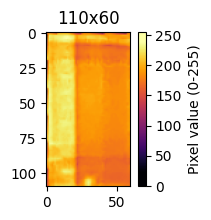

In [13]:
module = modules[0]
print(module)
module.plot()

# Définition des extracteurs

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import time

## Indicateurs statistiques "basiques"

In [15]:
# Transformeur qui renvoie le dataframe des indicateurs statistiques
class BaseStatsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features statistiques à extraire
        self.feature_names_ = PVModule.get_stats_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va récupérer les dict stats
        stats_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Stockage du dict stats
            module.extract_stats()
            stats_dicts.append(module.stats)
        # On renvoie le dataframe des dict stats
        return pd.DataFrame.from_records(stats_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des indicateurs statistiques.

In [16]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_stats()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.32 minutes (0.0036430054275495543 secondes par module)


## Vecteurs GLCM 

In [17]:
# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = PVModule.get_glcm_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vector_dicts = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_glcm()
            glcm_vector_dicts.append(module.glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame.from_records(glcm_vector_dicts, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des vecteurs GLCM.

In [18]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_glcm()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 2.67 minutes (0.029971534547487775 secondes par module)


## Densité de contours

In [19]:
# Transformeur qui renvoie la densité de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = PVModule.get_edge_density_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer la densité de contours pour chaque module PV
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur GLCM
            module.extract_edge_density()
            edge_densities.append(module.edge_density)
        # On renvoie le dataframe des densités de contours
        return pd.DataFrame(edge_densities, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des densités de contours.

In [20]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_edge_density()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.01 minutes (0.00010981779502276939 secondes par module)


## Entropie

In [21]:
# Transformeur qui renvoie les caractéristiques de l'entropie de la matrice de températures du module
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = PVModule.get_entropy_feature_names()

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Récupération de l'objet PVModule correspondant
            module = PVModule.get_module(image_path=img_path)
            # Extraction et stockage du vecteur de l'entropie
            module.extract_entropy()
            entropy_vectors.append(module.entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame.from_records(entropy_vectors, index=X.index, columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

Pour gagner du temps pendant l'entraînement des pipelines, on lance l'extraction des cartes d'entropie.

In [22]:
start  = time.time()

for module in PVModule.get_known_modules():
    module.extract_entropy()

end = time.time()
elapsed = end - start

print(f"Temps nécessaire : {elapsed/60:.2f} minutes ({elapsed/len(modules)} secondes par module)")

Temps nécessaire : 0.57 minutes (0.006375596826109559 secondes par module)


# Séparation du jeu de données


Train, Validation & Test.


In [23]:
TRAIN_SIZE = .8
TEST_SIZE = .2
VALIDATION_SIZE = 1. - (TRAIN_SIZE + TEST_SIZE)
RANDOM_STATE = 42
# RANDOM_STATE = None  # Laisser 'random_state' à None pour obtenir un partage aléatoire non-reproductible

In [24]:
from sep24_cds_pv.features.model_selection import improved_train_test_validation_split

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

In [25]:
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

In [26]:
total_elements = sum([len(split) for split_name, split in zip(splits._fields, splits) if split_name.startswith("y")])

def display_dataset_proportions(dataset: pd.Series):
    display(pd.concat([pd.Series(dataset).value_counts(),
                       pd.Series(dataset).value_counts(normalize=True) * 100],
                      axis=1))


for split_name, split in zip(splits._fields, splits):
    if not split_name.startswith("y"):
        continue
    print("---------------------------------")
    print(f"Split: {split_name}\n")
    nb_elements = len(split)
    print(f"Nombre d'éléments: {nb_elements}")
    print(f"Proportion du jeu complet: {nb_elements/total_elements*100:.2f}%")
    if not split.empty:
        display_dataset_proportions(split)


---------------------------------
Split: y_train

Nombre d'éléments: 4270
Proportion du jeu complet: 79.99%


,count,proportion
Classe,,
healthy panel,1165,27.283372
hot cell,676,15.831382
junction box heat,640,14.988290
substring open circuit,475,11.124122
short circuit panel,341,7.985948
bottom dirt,302,7.072600
Debris cover,268,6.276347
shadow,242,5.667447
break,104,2.435597


---------------------------------
Split: y_test

Nombre d'éléments: 1068
Proportion du jeu complet: 20.01%


,count,proportion
Classe,,
healthy panel,291,27.247191
hot cell,169,15.823970
junction box heat,160,14.981273
substring open circuit,119,11.142322
short circuit panel,86,8.052434
bottom dirt,75,7.022472
Debris cover,67,6.273408
shadow,61,5.711610
break,26,2.434457


---------------------------------
Split: y_validation

Nombre d'éléments: 0
Proportion du jeu complet: 0.00%


# Modélisation

## Classes complémentaires

### Wrapper XGBoost

XGBoost ne travaille que sur des valeurs numériques.

Pour pouvoir néanmoins utiliser un classifieur XGBoost comme les autres modèles Scikit-learn, il est nécessaire de le 'wrapper' dans un estimateur qui intègre les étapes d'encodage/décodage des classes de défaut dans le vecteur 'y'.

In [27]:
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import NotFittedError

class XGBClassifierWithLabelEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, **xgb_params):
        # Dynamically store XGBoost parameters
        for key, value in xgb_params.items():
            setattr(self, key, value)
        self.encoder = LabelEncoder()
        self.clf = None
        self._is_fitted = False

    def fit(self, X, y):
        y_enc = self.encoder.fit_transform(y)

        # Extract valid XGB params from self
        params = self._get_xgb_params()
        self.clf = XGBClassifier(**params)
        self.clf.fit(X, y_enc)

        # Mark as fitted and expose attributes
        self._is_fitted = True
        self.classes_ = self.encoder.classes_
        self.n_features_in_ = X.shape[1]
        if hasattr(X, "columns"):
            self.feature_names_in_ = X.columns

        return self

    def predict(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        y_pred_enc = self.clf.predict(X)
        return self.encoder.inverse_transform(y_pred_enc)

    def predict_proba(self, X):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.predict_proba(X)

    def get_params(self, deep=True):
        return {
            k: v for k, v in self.__dict__.items()
            if not k.startswith('_') and k not in ['encoder', 'clf']
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def _get_xgb_params(self):
        valid_params = XGBClassifier().get_params()
        return {
            k: v for k, v in self.get_params().items()
            if k in valid_params
        }
    
    @property
    def feature_importances_(self):
        if not self._is_fitted:
            raise NotFittedError("This estimator is not fitted yet. Call 'fit' first.")
        return self.clf.feature_importances_

    def __sklearn_is_fitted__(self):
        return hasattr(self, "_is_fitted") and self._is_fitted

## Configuration du pipeline

### Pipeline générique

In [28]:
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import VarianceThreshold

# Pipeline générique
pipe = Pipeline([
    ('features', FeatureUnion([
        ('stats', BaseStatsExtractor()),
        ('glcm', GLCMExtractor()),
        ("edgedensity", EdgeDensityExtractor()),
        ("entropy", EntropyExtractor()),
    ])),
    ('dropper', VarianceThreshold()),
    ('scaler', "passthrough"),
    ('selector', "passthrough"),
    ('sampler', "passthrough"),
    ('model', XGBClassifierWithLabelEncoding())
],
# Le paramètre 'memory' permet de mettre en cache les transformeurs après entraînement - on gagne du temps sur le GridSearch
# memory="./cache_pipeline",
# L'ajout de .set_output() permet de manipuler des dataframes pandas au lieu de simples arrays numpy à chaque étape
# Cela permet de conserver les noms des colonnes et d'y voir plus clair 
).set_output(transform="pandas")


### Paramétrage

Pour une explication de la méthodologie utilisée pour la recherche des meilleurs paramètres des pipelines, voir la section [Méthodologie](#Methodologie) en début de notebook.

#### Samplers

Paramétrage des samplers à évaluer.

In [29]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN

SAMPLER_RANDOM_STATE = 42

sampler_param_grid = [
    {
        "sampler": [
            SMOTETomek(),
            RandomOverSampler(),
            ADASYN(),
            SMOTE(),
            RandomUnderSampler(),
            ClusterCentroids(),
            SMOTEENN(),
            ],
        # Attention : sans random_state fixe, les samplers gardent une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
        "sampler__random_state": [SAMPLER_RANDOM_STATE],
    },
    {
        "sampler": [
            "passthrough",
            ],
    },
]

#### Estimateur

Paramétrage de l'estimateur.

In [30]:
model_param_grid = [
    {
    "model": [XGBClassifierWithLabelEncoding()],
    # tree_method="auto" et eval_metric="logloss" sont les valeurs par défaut du XGBClassifier
    "model__tree_method": ["auto"],
    "model__eval_metric": ["logloss"],
    # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": [42],
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": [6],
    "model__min_child_weight": [1],
    "model__colsample_bytree": [1.],
    "model__subsample": [1.0],
    "model__learning_rate": [0.3],
    "model__n_estimators": [100],
    },
    # {
    #     'model': [XGBClassifierWithLabelEncoding()],
    #     # tree_method='auto' et eval_metric='logloss' sont les valeurs par défaut du XGBClassifier
    #     'model__tree_method': ['auto'],
    #     'model__eval_metric': ['logloss'],
    #     # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    #     'model__random_state': [42],
    #     # Paramètres optimaux trouvés lors de la phase exploratoire
    #     'model__max_depth': [6],  # Par défaut: 6
    #     'model__min_child_weight': [1],  # Par défaut: 1
    #     'model__colsample_bytree': [1.],  # Par défaut: 1
    #     'model__subsample': [1.0],  # Par défaut: 1.
    #     'model__learning_rate': [0.3],  # (ou eta) Par défaut: 0.3
    #     'model__n_estimators': [100],  # Par défaut: 100
    #     # Grille d'exploration
    #     # 'model__max_depth': [4, 6, 8],
    #     # 'model__min_child_weight': [1, 6, 12],
    #     # 'model__subsample': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    #     # 'model__n_estimators': [100, 200, 300, 500, 600, 700, 800, 900, 1000],
    #     # 'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    # },
]

### Combinaison de l'ensemble des paramètres

In [31]:
param_grids = []

for model_dict in model_param_grid:
    for sampler_dict in sampler_param_grid:
        full_dict = {}
        full_dict.update(model_dict)
        full_dict.update(sampler_dict)
        param_grids.append(full_dict)

In [32]:
len(param_grids)

2

### Fonctions d'extraction des caractéristiques du pipeline

In [33]:
# Type de modèle
def extract_model_name(pipeline):
    model = pipeline[5]
    return model.__class__.__name__ if model is not None else 'unknown'

# Extracteurs / Features
def extract_extractor_names(pipeline):
    extractors_dict = pipeline[0].named_transformers
    extractor_strings = []
    for feature_key, extractor in extractors_dict.items():
        extractor_string = feature_key.capitalize()
        extractor_string = f"no{extractor_string}" if isinstance(extractor, str) else extractor_string
        extractor_strings.append(extractor_string)
    return "_".join(extractor_strings)

# Scaler
def extract_scaler_name(pipeline):
    scaler = pipeline[2]
    return scaler.__class__.__name__ if not isinstance(scaler, str) else 'noScaling'

# Selector
def extract_selector_name(pipeline):
    selector = pipeline[3]
    return selector.__class__.__name__ if not isinstance(selector, str) else 'noReduction'

# Sampler
def extract_sampler_name(pipeline):
    sampler = pipeline[4]
    return sampler.__class__.__name__ if not isinstance(sampler, str) else 'noSampling'

# Concaténation de l'ensemble des caractéristiques
def get_pipeline_shortdescription(pipeline):

    model_name = extract_model_name(pipeline)
    sampler_name = extract_sampler_name(pipeline)
    features = extract_extractor_names(pipeline)
    scaler_name = extract_scaler_name(pipeline)
    selector_name = extract_selector_name(pipeline)
    
    return f"{model_name}_{sampler_name}_{features}_{scaler_name}_{selector_name}"


## Activation de MLflow

In [34]:
import arrow

current_dt = arrow.utcnow()

if ACTIVATE_MLFLOW:

    import mlflow
    import logging

    # Configuration du serveur MLflow
    mlflow.set_tracking_uri(MLFLOW_URI)

    # Définition des noms des Experiments
    MLFLOW_EXPERIMENT_NAME_PATTERN = "PVF10_MLstats_{suffix}"

    # Suppression des messages de log émis par MLflow
    mlflow_logger = logging.getLogger('mlflow')
    mlflow_logger.setLevel(logging.WARNING)
    logging.getLogger('mlflow.utils.requirements_utils').setLevel(logging.ERROR)
    

## Validation croisée

### Fonction d'exécution du GridSearchCV

In [35]:
import time
import tempfile
from pprint import pprint
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sep24_cds_pv.features.model_selection import display_results


# Exécution du GridSearch
def execute_gridsearch(pipeline_param_grid):

    start = time.time()

    base_model = pipeline_param_grid.get('model')[0]
    model_name = base_model.__class__.__name__
    
    print("-------------------------------------------------------------------------")
    print(f"Evaluation des pipelines basés sur {model_name}")
    print("-------------------------------------------------------------------------")
    print()

    grid = GridSearchCV(estimator=pipe, 
                        param_grid=pipeline_param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},
                        refit='f1_macro', 
                        return_train_score=True,
                        n_jobs=-1, 
                        verbose=1)
    grid.fit(X_train, y_train)

    end = time.time()
    print(f"Temps nécessaire : {(end - start)/60:.2f} minutes")

    display(grid)

    # Affichage des résultats (classement par f1-score macro)
    print()
    print("Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :")
    print("Meilleurs paramètres (f1 macro) : ")
    pprint(grid.best_params_)
    print("Meilleur score (f1 macro): ", grid.best_score_)

    results = pd.DataFrame(grid.cv_results_)

    # Ajout de la description macro de chaque pipeline évalué
    for idx, params in results['params'].items():
        c_pipe = clone(grid.estimator)
        c_pipe.set_params(**params)
        c_pipe_description = get_pipeline_shortdescription(c_pipe)
        results.loc[idx, "pipeline_description"] = c_pipe_description

    # Ajout du nombre de features avant et après sélection (réduction de dimension), pour le meilleur estimateur
    best_idx = grid.best_index_
    n_features_pre_selector = grid.best_estimator_[:3].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_pre_selector"] = n_features_pre_selector
    n_features_post_selector = grid.best_estimator_[:4].transform(X_test).shape[1]
    results.loc[best_idx, "n_features_post_selector"] = n_features_post_selector

    # Affichage des résultats
    display(results[['pipeline_description',
                     'rank_test_f1_macro',
                     'params', 
                     'mean_fit_time', 'mean_score_time', 
                     'mean_test_accuracy', 'std_test_accuracy', 
                     'mean_test_f1_macro', 'std_test_f1_macro',
                     ]]
            .sort_values('mean_test_f1_macro', ascending=False))

    return grid, results


### Fonctions de log de MLflow

In [36]:
if ACTIVATE_MLFLOW:

    import mlflow.sklearn
    import mlflow.sklearn.utils

    def mlflow_log_standard(current_results, i):
        """Log info for standard run"""

        params = current_results.loc[i, 'params']

        # Log pipeline description as tag
        mlflow.set_tag("description", current_results.loc[i, "pipeline_description"])

        # Log hyperparameters
        mlflow.log_params(params)

        # Log mean and std scores, mean and std times, ranks, split_scores, n_features
        for name in current_results.columns:
            if name.startswith(("mean_test_", "rank_test_", "std_test_", "n_features_")) or name.endswith("_time"):
                mlflow.log_metric(name, current_results.loc[i, name])

        mlflow.set_tag("is_best", False)


    def mlflow_log_best(child_run, current_results, i, current_grid, figure=None, report_text=None, report_dict=None):
        """Log info for best run"""

        # Log the model
        best_model = current_grid.best_estimator_
        mlflow.sklearn.log_model(best_model, artifact_path="model", input_example=X_train[["Chemin"]])
        mlflow.set_tag("is_best", True)

        # Log pipeline html representation
        mlflow.sklearn.utils._log_estimator_html(child_run.info.run_id, best_model)

        # Log test metrics, if any
        for score_name in [name for name in current_results.columns if name.startswith("test_")]:
            mlflow.log_metric(score_name, current_results.loc[i, score_name])
        
        # Log classification matrix
        if figure is not None:
            with tempfile.TemporaryDirectory() as tmp_dir:
                cm_path = Path(tmp_dir) / "confusion_matrix.png"
                figure.savefig(cm_path)
                mlflow.log_artifact(cm_path)
        
        # Log classification reports
        if report_text is not None:
            mlflow.log_text(report_text, "classification_report.txt")
        if report_dict is not None:
            mlflow.log_dict(report_dict, "classification_report.yaml")

        mlflow.set_tag("is_best", True)


### Exécution du GridSearchCV

In [37]:
from joblib import parallel_backend
from sklearn.exceptions import ConvergenceWarning
import warnings

results_list = []

# mlflow_client = mlflow.tracking.MlflowClient()

for param_idx, param_grid in enumerate(param_grids):

    print()
    print(f"Param_grid {param_idx+1}/{len(param_grids)}")

    # with parallel_backend('loky'):  # Paramétrage par défaut - multiprocessing
    with parallel_backend('threading'):  # Important pour permettre le "partage" de la classe PVModule entre tous les jobs

        with warnings.catch_warnings():

            # Filtrage des ConvergenceWarnings émis par scikit-learn pour LogisticRegression
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            # Filtrage des FutureWarnings émis par scikit-learn / En version <=0.5.7, UMAP utilise un nom de paramètre prochainement déprécié
            warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn", message=r"^'force_all_finite' was renamed.*")
            # Filtrage des UserWarnings émis par joblib (probablement une opération de lecture du cache qui dure trop longtemps)
            warnings.filterwarnings("ignore", category=UserWarning, module="joblib", message=r"^Persisting input arguments took.*")
        
            # Exécution du GridSearchCV
            current_grid, current_results = execute_gridsearch(param_grid)

    # Ajout des résultats courants à la liste
    results_list.append(current_results)

    if ACTIVATE_MLFLOW:

        base_model = param_grid.get('model')[0]
        model_name = base_model.__class__.__name__
        
        mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(suffix=model_name,
                                                                    # date_string=current_dt.format('YYYYMMDD_HHmm'),
                                                                    # date_string=current_dt.format('YYYYMMDD'),
                                                                    )
                              )
        mlflow.set_experiment_tag("estimator", model_name)

        with mlflow.start_run() as parent_run:

            n_candidates = len(current_results['params'])
            best_index = current_grid.best_index_

            # Log de la grille de paramètres et des paramètres additionnels
            mlflow.log_params(param_grid)
            mlflow.log_param("cv", current_grid.cv)
            mlflow.log_param("scoring", current_grid.scoring)
            mlflow.log_param("total_candidates", n_candidates)

            # Log du dataframe de l'ensemble des résultats
            with tempfile.TemporaryDirectory() as tmp_dir:
                results_path = Path(tmp_dir) / "cv_results.csv"
                current_results.to_csv(results_path, index=False)
                mlflow.log_artifact(results_path)

            for i in range(n_candidates):

                # Si on ne souhaite logger que le "best run"
                if i == best_index:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)
                        mlflow_log_best(child_run, current_results, i, current_grid)

                # Si on souhaite logger tous les runs
                elif MLFLOW_LOG_ALL_RUNS:

                    with mlflow.start_run(run_name=f"{parent_run.info.run_name}_{i}", nested=True) as child_run:
                        mlflow_log_standard(current_results, i)




Param_grid 1/2
-------------------------------------------------------------------------
Evaluation des pipelines basés sur XGBClassifierWithLabelEncoding
-------------------------------------------------------------------------

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Temps nécessaire : 0.93 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('glcm',
                                                                        GLCMExtractor()),
                                                                       ('edgedensity',
                                                                        EdgeDensityExtractor()),
                                                                       ('entropy',
                                                                        EntropyExtractor())])),
                                       ('dropper', VarianceThreshold()),
                                       ('scaler', 'passthrough'),
                                       ('selector', 'passthrou...
                         'model__n_estimators': [100],
                         'model__random_state': [42], 'model__subsample': [1.0],
                         'model__tree_method': ['auto'],
                         'sampler': [SMOTETomek(), RandomOverSampler(),
                                     ADASYN(), SMOTE(), RandomUnderSampler(),
                                     ClusterCentroids(), SMOTEENN()],
                         'sampler__random_state': [42]},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'model': XGBClassifierWithLabelEncoding(),
 'model__colsample_bytree': 1.0,
 'model__eval_metric': 'logloss',
 'model__learning_rate': 0.3,
 'model__max_depth': 6,
 'model__min_child_weight': 1,
 'model__n_estimators': 100,
 'model__random_state': 42,
 'model__subsample': 1.0,
 'model__tree_method': 'auto',
 'sampler': RandomOverSampler(),
 'sampler__random_state': 42}
Meilleur score (f1 macro):  0.7461327017906472


,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
1,XGBClassifierWithLabelEncoding_RandomOverSampl...,1,{'model': XGBClassifierWithLabelEncoding(colsa...,21.749453,0.427225,0.823185,0.014719,0.746133,0.025571
2,XGBClassifierWithLabelEncoding_ADASYN_Stats_Gl...,2,{'model': XGBClassifierWithLabelEncoding(colsa...,21.911689,0.619931,0.820141,0.007574,0.744110,0.014900
3,XGBClassifierWithLabelEncoding_SMOTE_Stats_Glc...,3,{'model': XGBClassifierWithLabelEncoding(colsa...,16.997046,0.248128,0.811710,0.015959,0.734505,0.017631
0,XGBClassifierWithLabelEncoding_SMOTETomek_Stat...,4,{'model': XGBClassifierWithLabelEncoding(colsa...,26.069808,0.424331,0.811944,0.020757,0.730158,0.024620
6,XGBClassifierWithLabelEncoding_SMOTEENN_Stats_...,5,{'model': XGBClassifierWithLabelEncoding(colsa...,9.393600,0.215224,0.738407,0.020451,0.687548,0.028036
4,XGBClassifierWithLabelEncoding_RandomUnderSamp...,6,{'model': XGBClassifierWithLabelEncoding(colsa...,9.399898,0.284952,0.668150,0.026523,0.624625,0.022650
5,XGBClassifierWithLabelEncoding_ClusterCentroid...,7,{'model': XGBClassifierWithLabelEncoding(colsa...,9.650551,0.325512,0.599297,0.014652,0.566636,0.009053


🏃 View run gaudy-owl-131_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923/runs/d3aa45be7f864ca5916c8eb607fd7aea
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923


🏃 View run gaudy-owl-131_1 at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923/runs/146b450e8cb04b6a806384310cbced78
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923
🏃 View run gaudy-owl-131_2 at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923/runs/430d1a9f96894e85b80daec45639974e
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923
🏃 View run gaudy-owl-131_3 at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923/runs/1a45daa0e41640118c30900e880f2fd9
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923
🏃 View run gaudy-owl-131_4 at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923/runs/6a750302d8124a7c9c324f79784d9a6b
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923
🏃 View run gaudy-owl-131_5 at: http://mlflow

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('stats',
                                                                        BaseStatsExtractor()),
                                                                       ('glcm',
                                                                        GLCMExtractor()),
                                                                       ('edgedensity',
                                                                        EdgeDensityExtractor()),
                                                                       ('entropy',
                                                                        EntropyExtractor())])),
                                       ('dropper', VarianceThreshold()),
                                       ('scaler', 'passthrough'),
                                       ('selector', 'passthrou...
                         'model__eval_metric': ['logloss'],
                         'model__learning_rate': [0.3], 'model__max_depth': [6],
                         'model__min_child_weight': [1],
                         'model__n_estimators': [100],
                         'model__random_state': [42], 'model__subsample': [1.0],
                         'model__tree_method': ['auto'],
                         'sampler': ['passthrough']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=1)


Résultats obtenus par le GridSearch (sur le jeu d'apprentissage) :
Meilleurs paramètres (f1 macro) : 
{'model': XGBClassifierWithLabelEncoding(colsample_bytree=1.0, eval_metric='logloss',
                               learning_rate=0.3, max_depth=6,
                               min_child_weight=1, n_estimators=100,
                               random_state=42, subsample=1.0,
                               tree_method='auto'),
 'model__colsample_bytree': 1.0,
 'model__eval_metric': 'logloss',
 'model__learning_rate': 0.3,
 'model__max_depth': 6,
 'model__min_child_weight': 1,
 'model__n_estimators': 100,
 'model__random_state': 42,
 'model__subsample': 1.0,
 'model__tree_method': 'auto',
 'sampler': 'passthrough'}
Meilleur score (f1 macro):  0.7407018588426453


,pipeline_description,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro
0,XGBClassifierWithLabelEncoding_noSampling_Stat...,1,{'model': XGBClassifierWithLabelEncoding(colsa...,4.840127,0.338971,0.823653,0.013728,0.740702,0.022822


🏃 View run treasured-ant-644_0 at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923/runs/1d55958fbfa0447b9dd49684b2bf30b6
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923
🏃 View run treasured-ant-644 at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923/runs/2a82e38a65024fa7a19b069b5ed57184
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/872932124860684923


## Compilation des résultats

In [38]:
results_df = pd.concat(results_list, axis=0).reset_index(drop=True).sort_values("mean_test_f1_macro", ascending=False)
display(results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__colsample_bytree,param_model__eval_metric,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,...,split0_train_f1_macro,split1_train_f1_macro,split2_train_f1_macro,split3_train_f1_macro,split4_train_f1_macro,mean_train_f1_macro,std_train_f1_macro,pipeline_description,n_features_pre_selector,n_features_post_selector
1,21.749453,0.279265,0.427225,0.234543,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_RandomOverSampl...,76.0,76.0
2,21.911689,3.938846,0.619931,0.248523,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_ADASYN_Stats_Gl...,NaN,NaN
7,4.840127,0.049938,0.338971,0.074017,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_noSampling_Stat...,76.0,76.0
3,16.997046,0.754695,0.248128,0.127097,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_SMOTE_Stats_Glc...,NaN,NaN
0,26.069808,0.308847,0.424331,0.260522,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.994062,0.996003,0.995302,0.994804,0.993453,0.994725,0.000898,XGBClassifierWithLabelEncoding_SMOTETomek_Stat...,NaN,NaN
6,9.393600,0.790897,0.215224,0.104638,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.826276,0.834067,0.818155,0.824037,0.823398,0.825186,0.005177,XGBClassifierWithLabelEncoding_SMOTEENN_Stats_...,NaN,NaN
4,9.399898,1.460680,0.284952,0.180772,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.651240,0.700822,0.682570,0.689557,0.693925,0.683623,0.017245,XGBClassifierWithLabelEncoding_RandomUnderSamp...,NaN,NaN
5,9.650551,1.105747,0.325512,0.156798,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.608923,0.633066,0.625243,0.587804,0.614451,0.613897,0.015505,XGBClassifierWithLabelEncoding_ClusterCentroid...,NaN,NaN


## Sauvegarde du fichier de résultats

Dans le cas où MLflow n'est pas utilisé, on peut stocker l'ensemble des résultats de recherche dans des fichiers nommés en fonction de la date et de l'heure d'exécution.

In [39]:
RESULTS_DIR = "./ML_stats_results"
results_dirpath = Path(RESULTS_DIR)

if not results_dirpath.exists():
    results_dirpath.mkdir()

filepath = results_dirpath / f"results_{current_dt.format('YYYYMMDD_HHmm')}.csv"
print(f"Sauvegarde du fichier {filepath}")
results_df.to_csv(filepath, index=False, sep=";")

Sauvegarde du fichier ML_stats_results\results_20250709_1716.csv


# Exploration des résultats

In [40]:
results_df['model_name'] = results_df['param_model'].apply(lambda model_object: model_object.__class__.__name__)

# Pour l'infobulle : construire une chaîne avec tous les paramètres
def format_params(param_dict):
    params_str = '<br>'.join(f"   {k}={v}" for k, v in param_dict.items() if k != "model")
    return f"<br>{params_str}"

results_df['params_str'] = results_df['params'].apply(format_params)


In [41]:
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__colsample_bytree,param_model__eval_metric,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,...,split2_train_f1_macro,split3_train_f1_macro,split4_train_f1_macro,mean_train_f1_macro,std_train_f1_macro,pipeline_description,n_features_pre_selector,n_features_post_selector,model_name,params_str
1,21.749453,0.279265,0.427225,0.234543,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_RandomOverSampl...,76.0,76.0,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...
2,21.911689,3.938846,0.619931,0.248523,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_ADASYN_Stats_Gl...,NaN,NaN,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...
7,4.840127,0.049938,0.338971,0.074017,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_noSampling_Stat...,76.0,76.0,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...
3,16.997046,0.754695,0.248128,0.127097,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,1.000000,1.000000,1.000000,1.000000,0.000000,XGBClassifierWithLabelEncoding_SMOTE_Stats_Glc...,NaN,NaN,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...
0,26.069808,0.308847,0.424331,0.260522,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.995302,0.994804,0.993453,0.994725,0.000898,XGBClassifierWithLabelEncoding_SMOTETomek_Stat...,NaN,NaN,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...
6,9.393600,0.790897,0.215224,0.104638,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.818155,0.824037,0.823398,0.825186,0.005177,XGBClassifierWithLabelEncoding_SMOTEENN_Stats_...,NaN,NaN,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...
4,9.399898,1.460680,0.284952,0.180772,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.682570,0.689557,0.693925,0.683623,0.017245,XGBClassifierWithLabelEncoding_RandomUnderSamp...,NaN,NaN,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...
5,9.650551,1.105747,0.325512,0.156798,XGBClassifierWithLabelEncoding(colsample_bytre...,1.0,logloss,0.3,6,1,...,0.625243,0.587804,0.614451,0.613897,0.015505,XGBClassifierWithLabelEncoding_ClusterCentroid...,NaN,NaN,XGBClassifierWithLabelEncoding,<br> model__colsample_bytree=1.0<br> model...


In [42]:
import plotly.express as px

def display_graphs(results_df, scores, x_axis, score_of_interest):

    # Trouver l’indice du meilleur modèle
    best_idx = results_df[score_of_interest].idxmax()

    results_df_highlight = results_df.copy()
    results_df_highlight["highlight"] = results_df_highlight.index == best_idx
    results_df_highlight = results_df_highlight.sort_values("highlight")

    # Création du graphique interactif pour chaque cas
    for score, title in scores.items():

        size_column = score.replace("mean", "std")
        size_column = size_column if size_column in results_df_highlight.columns else None

        fig = px.scatter(
            results_df_highlight,
            x=x_axis,
            y=score,
            color='highlight',
            size=size_column,
            hover_data={
                'model_name': True,
                'params_str': True,
                x_axis: ':.2f',
                score: ':.4f',
            },
            title=title,
        )
        fig.update_traces(showlegend=False)
        fig.show()


In [43]:
import plotly.express as px

# Définition des scores à afficher en fonction du temps
scores = {
    "mean_test_accuracy": "Précision vs Temps - Résultats du GridSearchCV sur les jeux de 'test' du GridSearch (folds extraits du jeu 'train')",
    "mean_test_f1_macro": "F1_macro vs Temps - Résultats du GridSearchCV sur les jeux de 'test' du GridSearch (folds extraits du jeu 'train')",
}

SCORE_OF_INTEREST = "mean_test_f1_macro"

# Trouver l’indice du meilleur modèle
best_idx = results_df[SCORE_OF_INTEREST].idxmax()

results_df["highlight"] = results_df.index == best_idx

# Création du graphique interactif pour chaque cas
for score, title in scores.items():

    size_column = score.replace("mean", "std")
    size_column = size_column if size_column in results_df.columns else None

    fig = px.scatter(
        results_df.sort_values("highlight"),
        x="mean_fit_time",
        y=score,
        color='highlight',
        size=size_column,
        hover_data={
            'model_name': True,
            'params_str': True,
            "mean_fit_time": ':.2f',
            score: ':.4f',
        },
        title=title,
    )
    fig.update_traces(showlegend=False)
    fig.show()


# Meilleur sampler

Les 3 meilleurs pipelines sont basés sur les oversamplers suivants :
- **RandomOverSampler** : Accuracy 82,32% / f1_score macro 74,61%
- **ADASYN** : Accuracy 82,01% / f1_score macro 74,41%
- Pas d'oversampling (**passthrough**) : Accuracy 82,37% / f1_score macro 74,07%

Il apparaît que l'oversampler **RandomOverSampler** permet d'obtenir un meilleur f1_score macro. Cependant, l'oversampler **ADASYN** est très proche. Sans oversampling (**passthrough**), l'accuracy est meilleure, et le f1_score n'est pas si loin.

**Note importante** : malgré le choix d'une valeur `random_state` fixe pour les différentes exécutions de ce notebook, en fait les scores ne sont jamais rigoureusement reproductibles... et le meilleur pipeline n'est jamais le même. On retrouve cependant régulièremenet dans le trio de tête les 3 options présentées ci-dessus. \
En conséquence, on choisit de conserver les 3 options comme "best pipelines" pour la suite du notebook.

In [44]:
best_pipelines = {}

In [45]:
best_pipelines["XGBoost_RandomOversampler"] = {
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "scaler": "passthrough",
    "selector": "passthrough",
    "sampler": RandomOverSampler(),
    "sampler__random_state": SAMPLER_RANDOM_STATE,
    "model": XGBClassifierWithLabelEncoding(),
    # tree_method="auto" et eval_metric="logloss" sont les valeurs par défaut du XGBClassifier
    "model__tree_method": "auto",
    "model__eval_metric": "logloss",
    # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 42,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": 6,
    "model__min_child_weight": 1,
    "model__colsample_bytree": 1.,
    "model__subsample": 1.0,
    "model__learning_rate": 0.3,
    "model__n_estimators": 100,
}

In [46]:
best_pipelines["XGBoost_ADASYN"] = {
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "scaler": "passthrough",
    "selector": "passthrough",
    "sampler": ADASYN(),
    "sampler__random_state": SAMPLER_RANDOM_STATE,
    "model": XGBClassifierWithLabelEncoding(),
    # tree_method="auto" et eval_metric="logloss" sont les valeurs par défaut du XGBClassifier
    "model__tree_method": "auto",
    "model__eval_metric": "logloss",
    # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": 42,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": 6,
    "model__min_child_weight": 1,
    "model__colsample_bytree": 1.,
    "model__subsample": 1.0,
    "model__learning_rate": 0.3,
    "model__n_estimators": 100,
}

In [47]:
best_pipelines["XGBoost_noSampling"] = {
    "features__stats": BaseStatsExtractor(),
    "features__edgedensity": EdgeDensityExtractor(),
    "features__entropy": EntropyExtractor(),
    "features__glcm": GLCMExtractor(),
    "scaler": "passthrough",
    "selector": "passthrough",
    "sampler": "passthrough",
    "model": XGBClassifierWithLabelEncoding(),
    # tree_method="auto" et eval_metric="logloss" sont les valeurs par défaut du XGBClassifier
    "model__tree_method": "auto",
    "model__eval_metric": "logloss",
    # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
    "model__random_state": SAMPLER_RANDOM_STATE,
    # Paramètres optimaux trouvés lors de la phase exploratoire
    "model__max_depth": 6,
    "model__min_child_weight": 1,
    "model__colsample_bytree": 1.,
    "model__subsample": 1.0,
    "model__learning_rate": 0.3,
    "model__n_estimators": 100,
}

In [48]:
# best_pipelines["XGBoost_SMOTETomek"] = {
#     "features__stats": BaseStatsExtractor(),
#     "features__edgedensity": EdgeDensityExtractor(),
#     "features__entropy": EntropyExtractor(),
#     "features__glcm": GLCMExtractor(),
#     "scaler": "passthrough",
#     "selector": "passthrough",
#     "sampler": SMOTETomek(),
#     "sampler__random_state": SAMPLER_RANDOM_STATE,
#     "model": XGBClassifierWithLabelEncoding(),
#     # tree_method="auto" et eval_metric="logloss" sont les valeurs par défaut du XGBClassifier
#     "model__tree_method": "auto",
#     "model__eval_metric": "logloss",
#     # Attention : sans random_state fixe, XGBoost garde une part d'aléatoire et les résultats ne sont pas rigoureusement reproductibles
#     "model__random_state": 42,
#     # Paramètres optimaux trouvés lors de la phase exploratoire
#     "model__max_depth": 6,
#     "model__min_child_weight": 1,
#     "model__colsample_bytree": 1.,
#     "model__subsample": 1.0,
#     "model__learning_rate": 0.3,
#     "model__n_estimators": 100,
# }

## Fonction de comparaison

In [49]:
# La variable globale suivante permet d'activer ou non la vidange du cache de la classe PVModule
PVMODULE_EMPTY_VAULT = True

In [ ]:
from copy import deepcopy

def get_test_results(best_pipelines: dict, best_pipelines_results: pd.DataFrame, split_name: str):

    for estimator_name, params in best_pipelines.items():

        print()
        print("-----------------------------------------------------------------------------------------")
        print(f"Evaluation du meilleur pipeline basé sur {estimator_name} pour le split {split_name}")
        print("-----------------------------------------------------------------------------------------")
        print()

        # Vidange du cache de la classe PVModule - permet de repartir d'une situation initiale "vierge" pour chaque pipeline
        if PVMODULE_EMPTY_VAULT:
            PVModule.empty_vault()

        # Enregistrement du split
        best_pipelines_results.loc[estimator_name, "dataset_split"] = split_name

        # Configuration du pipeline
        pipeline_params = deepcopy(params)
        pipe.set_params(**pipeline_params)

        # Entraînement #
        ################

        # Pre-processing
        start = time.time()
        resample_output = pipe[:5].fit_resample(X_train, y_train)
        end = time.time()
        train_preproc_time = end - start
        print(f"Entraînement - Temps de pre-processing: {train_preproc_time:.2f} secondes")

        # Adaptation pour tenir compte du pipeline "sampler__passthrough"
        if isinstance(resample_output, tuple):
            X_train_resampled, y_train_resampled = resample_output
        else:
            X_train_resampled, y_train_resampled = resample_output, y_train

        # Entraînement
        start = time.time()
        pipe[5].fit(X_train_resampled, y_train_resampled)
        end = time.time()
        train_fit_time = end - start
        print(f"Entraînement - Temps de fit: {train_fit_time:.2f} secondes")

        # Entraînement - Temps total
        total_train_time = train_preproc_time + train_fit_time
        print(f"Temps total d'entraînement (pre-processing + fit): {total_train_time:.2f} secondes")

        # Affichage
        display(pipe)

        # Prédictions #
        ###############

        # Pre-processing
        # !!!! IMPORTANT !!!! L'étape d'oversampling est bypassée !
        # Elle n'a pas de sens lors de la prédiction sur le jeu de test.
        # En conséquence, il n'est pas possible d'obtenir la sortie de cette étape par les méthodes .resample() ou .transform().
        # On se retrouve dans cette situation parce qu'on souhaite mesurer séparément le temps de préprocessing et le temps de prédiction.
        # Si on fait directement .predict() sur le pipeline entier, ça se débrouille tout seul sans problème...
        start = time.time()
        X_test_transformed = pipe[:4].transform(X_test)
        end = time.time()
        predict_preproc_time = end - start
        print(f"Prédiction - Temps de pre-processing: {predict_preproc_time:.2f} secondes")

        # Calcul des prédictions sur le jeu de test
        start = time.time()
        y_test_pred = pipe[5].predict(X_test_transformed)
        end = time.time()
        predict_pred_time = end - start
        print(f"Prédiction - Temps de prédiction: {predict_pred_time:.2f} secondes")

        # Prédiction - Temps total
        total_pred_time = predict_preproc_time + predict_pred_time
        print(f"Temps total de prédiction (pre-processing + prediction): {total_pred_time:.2f} secondes")

        # Calcul des scores
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
        test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
        test_recall_macro = recall_score(y_test, y_test_pred, average="macro")
        test_recall_weighted = recall_score(y_test, y_test_pred, average="weighted")
        test_precision_macro = precision_score(y_test, y_test_pred, average="macro")
        test_precision_weighted = precision_score(y_test, y_test_pred, average="weighted")
        
        # Ajout des scores obtenus dans le dataframe final
        best_pipelines_results.loc[estimator_name, "test_accuracy"] = test_accuracy
        best_pipelines_results.loc[estimator_name, "test_f1_macro"] = test_f1_macro
        best_pipelines_results.loc[estimator_name, "test_f1_weighted"] = test_f1_weighted
        best_pipelines_results.loc[estimator_name, "test_recall_macro"] = test_recall_macro
        best_pipelines_results.loc[estimator_name, "test_recall_weighted"] = test_recall_weighted
        best_pipelines_results.loc[estimator_name, "test_precision_macro"] = test_precision_macro
        best_pipelines_results.loc[estimator_name, "test_precision_weighted"] = test_precision_weighted

        # Ajout des temps
        best_pipelines_results.loc[estimator_name, "train_preproc_time"] = train_preproc_time
        best_pipelines_results.loc[estimator_name, "train_fit_time"] = train_fit_time
        best_pipelines_results.loc[estimator_name, "total_train_time"] = total_train_time
        best_pipelines_results.loc[estimator_name, "predict_preproc_time"] = predict_preproc_time
        best_pipelines_results.loc[estimator_name, "predict_pred_time"] = predict_pred_time
        best_pipelines_results.loc[estimator_name, "total_pred_time"] = total_pred_time

        # Ajout du nombre de features avant et après sélection (réduction de dimension), pour le meilleur estimateur
        n_features_pre_selector = pipe[:3].transform(X_test).shape[1]
        best_pipelines_results.loc[estimator_name, "n_features_pre_selector"] = n_features_pre_selector
        n_features_post_selector = pipe[:4].transform(X_test).shape[1]
        best_pipelines_results.loc[estimator_name, "n_features_post_selector"] = n_features_post_selector

        # Affichage des résultats
        print()
        print("-------------------------------------------------------")
        print(f"Résultats obtenus sur le jeu de test du split {split_name} :")

        cm_figure, cr_text, cr_dict = display_results(y_test, y_test_pred)

        if ACTIVATE_MLFLOW:

            base_model = params.get('model')
            model_name = base_model.__class__.__name__
            
            mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME_PATTERN.format(suffix=f"{split_name}_BestPipelines"))

            with mlflow.start_run() as current_run:

                # Log model name as tag
                mlflow.set_tag("model", model_name)
                
                # Log hyperparameters
                mlflow.log_params(params)

                # Log all metrics
                for name in best_pipelines_results.columns:
                    mlflow.log_metric(name, best_pipelines_results.loc[estimator_name, name])

                # Log the model
                mlflow.sklearn.log_model(pipe, artifact_path="model", input_example=X_train[["Chemin"]])

                # Log pipeline html representation
                mlflow.sklearn.utils._log_estimator_html(current_run.info.run_id, pipe)

                # Log classification matrix
                with tempfile.TemporaryDirectory() as tmp_dir:
                    cm_path = Path(tmp_dir) / "confusion_matrix.png"
                    cm_figure.savefig(cm_path)
                    mlflow.log_artifact(cm_path)
                    
                # Log classification reports
                mlflow.log_text(cr_text, "classification_report.txt")
                mlflow.log_dict(cr_dict, "classification_report.yaml")

## Fonction d'affichage des graphes

In [51]:
import plotly.express as px
import plotly.graph_objects as go

def display_best_pipelines_graphs(best_pipelines_results):

    best_pipelines_results['pipeline_name'] = best_pipelines_results.index

    title_suffix = "<br>Attention, les temps affichés varient selon la machine utilisée"
    if PVMODULE_EMPTY_VAULT:
        title_suffix += "<br>Cache préprocessing : <span style='color:red'>désactivé</span>"
    else:
        title_suffix += "<br>Cache préprocessing : <span style='color:red'>activé</span>"

    # Création du graphique interactif 'score vs total_fit_time'
    for score, title in scores.items():

        fig = px.scatter(
            best_pipelines_results,
            x="total_train_time",
            y=score,
            color="pipeline_name",
            hover_data={
                'pipeline_name': True,
                "total_train_time": ':.2f',
                score: ':.4f',
            },
            title=title + title_suffix,
        )
        fig.update_traces(showlegend=True)
        fig.update_traces(marker=dict(size=10))
        fig.show()

    # Création du bargraph interactif 'times per estimator'
    fig = go.Figure()

    for step_time in ["train_preproc_time", "train_fit_time", "predict_preproc_time", "predict_pred_time"]:
        fig.add_trace(go.Bar(
            y=best_pipelines_results["pipeline_name"],
            x=best_pipelines_results[step_time],
            orientation='h',
            name=step_time,
        ))

    fig.update_layout(
        barmode='stack',
        title="Temps de pre-processing, entraînement et prédiction par estimateur" + title_suffix,
        )
    fig.show()

## Résultats sur le jeu de test

Juste par précaution, parce que ce notebook est utilisé en faisant des allers-retours entre les différentes parties : on s'assure qu'on utilise toujours le même split 80/20 de travail, sans les images 'doute_carre'.

In [52]:
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", remove_doute_carre=True)

splits = improved_train_test_validation_split(df_pvf10, 
                                              target_col="Classe", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              stratify=True,
                                              )

if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

Nb d'images dans l'ensemble d'entraînement : 4270
Nb d'images dans l'ensemble de test : 1068



-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost_RandomOversampler pour le split 80.20
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 102.05 secondes
Entraînement - Temps de fit: 1.98 secondes
Temps total d'entraînement (pre-processing + fit): 104.03 secondes


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy',
                                                 EntropyExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('sampler', RandomOverSampler(random_state=42)),
                ('model',
                 XGBClassifierWithLabel...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 25.44 secondes
Prédiction - Temps de prédiction: 0.02 secondes
Temps total de prédiction (pre-processing + prediction): 25.46 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


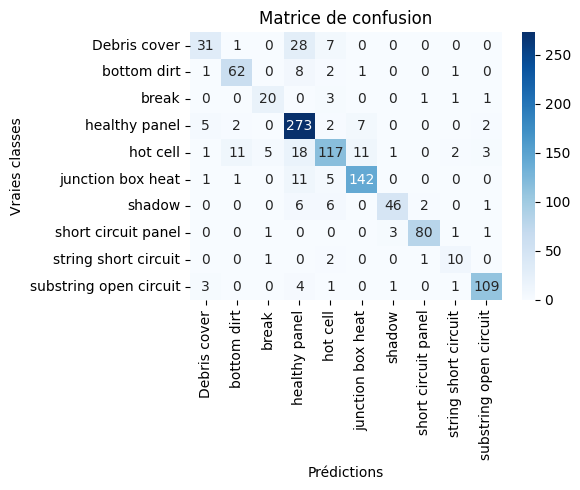

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.74      0.46      0.57        67
           bottom dirt       0.81      0.83      0.82        75
                 break       0.74      0.77      0.75        26
         healthy panel       0.78      0.94      0.85       291
              hot cell       0.81      0.69      0.75       169
     junction box heat       0.88      0.89      0.88       160
                shadow       0.90      0.75      0.82        61
   short circuit panel       0.95      0.93      0.94        86
  string short circuit       0.62      0.71      0.67        14
substring open circuit       0.93      0.92      0.92       119

              accuracy                           0.83      1068
             macro avg       0.82      0.79      0.80      1068
          weighted avg       0.83      0.83      0.83      1068



🏃 View run overjoyed-stag-330 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/6d313dfcf58c484a9c5275c22773d983
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost_ADASYN pour le split 80.20
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 101.68 secondes
Entraînement - Temps de fit: 2.53 secondes
Temps total d'entraînement (pre-processing + fit): 104.22 secondes


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy',
                                                 EntropyExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('sampler', ADASYN(random_state=42)),
                ('model',
                 XGBClassifierWithLabelEncoding(cl...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 25.88 secondes
Prédiction - Temps de prédiction: 0.02 secondes
Temps total de prédiction (pre-processing + prediction): 25.90 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


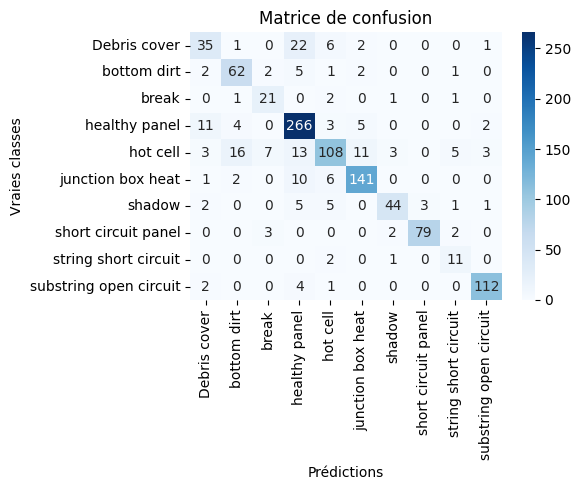

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.62      0.52      0.57        67
           bottom dirt       0.72      0.83      0.77        75
                 break       0.64      0.81      0.71        26
         healthy panel       0.82      0.91      0.86       291
              hot cell       0.81      0.64      0.71       169
     junction box heat       0.88      0.88      0.88       160
                shadow       0.86      0.72      0.79        61
   short circuit panel       0.96      0.92      0.94        86
  string short circuit       0.52      0.79      0.63        14
substring open circuit       0.94      0.94      0.94       119

              accuracy                           0.82      1068
             macro avg       0.78      0.80      0.78      1068
          weighted avg       0.83      0.82      0.82      1068



🏃 View run merciful-shrimp-846 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/a4c6cf898fd44dfb8378945ba47c9e7f
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost_noSampling pour le split 80.20
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 107.72 secondes
Entraînement - Temps de fit: 1.44 secondes
Temps total d'entraînement (pre-processing + fit): 109.16 secondes


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy',
                                                 EntropyExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'), ('sampler', 'passthrough'),
                ('model',
                 XGBClassifierWithLabelEncoding(classes_=arr...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 24.90 secondes
Prédiction - Temps de prédiction: 0.00 secondes
Temps total de prédiction (pre-processing + prediction): 24.90 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 80.20 :


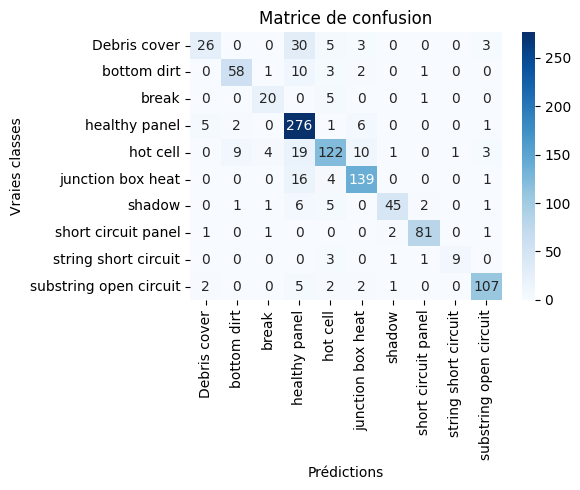

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.76      0.39      0.51        67
           bottom dirt       0.83      0.77      0.80        75
                 break       0.74      0.77      0.75        26
         healthy panel       0.76      0.95      0.85       291
              hot cell       0.81      0.72      0.76       169
     junction box heat       0.86      0.87      0.86       160
                shadow       0.90      0.74      0.81        61
   short circuit panel       0.94      0.94      0.94        86
  string short circuit       0.90      0.64      0.75        14
substring open circuit       0.91      0.90      0.91       119

              accuracy                           0.83      1068
             macro avg       0.84      0.77      0.80      1068
          weighted avg       0.83      0.83      0.82      1068



🏃 View run thundering-toad-900 at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658/runs/eee790bdfda14448affc7abba6d7ad20
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/301285799235823658


In [53]:
best_pipelines_results_80_20 = pd.DataFrame()

get_test_results(best_pipelines, best_pipelines_results_80_20, split_name="80.20")

In [54]:
best_pipelines_results_80_20 = best_pipelines_results_80_20.sort_values("test_f1_macro", ascending=False)
display(best_pipelines_results_80_20)

,dataset_split,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,train_preproc_time,train_fit_time,total_train_time,predict_preproc_time,predict_pred_time,total_pred_time,n_features_pre_selector,n_features_post_selector
XGBoost_RandomOversampler,80.20,0.833333,0.797673,0.828999,0.789112,0.833333,0.816836,0.834651,102.046485,1.983282,104.029767,25.439411,0.017236,25.456647,76.0,76.0
XGBoost_noSampling,80.20,0.826779,0.795259,0.820579,0.769130,0.826779,0.842420,0.830123,107.720348,1.437850,109.158197,24.896189,0.001122,24.897311,76.0,76.0
XGBoost_ADASYN,80.20,0.823034,0.780211,0.820568,0.795795,0.823034,0.777365,0.825665,101.683393,2.533453,104.216846,25.881774,0.016868,25.898642,76.0,76.0


In [55]:
# Définition des scores à afficher en fonction du temps
scores = {
    "test_accuracy": "Précision vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 80/20)",
    "test_f1_macro": "F1_macro vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 80/20)",
}

display_best_pipelines_graphs(best_pipelines_results_80_20)


### Observations

De façon inattendue, on constate que le temps de préprocessing pour l'entraînement est plus élevé pour le pipeline **noSampling** que pour les pipelines **ADASYN** et **RandomOversampler**...

En termes de performances, **RandomOversampler** confirme son léger avantage par rapport au **noSampling**, tant sur le f1_score macro (79,77% vs 79.53%) que sur l'accuracy (83,33% vs 82,68%).

## Résultats sur le jeu train/test de référence

Afin de comparer les résultats entre les différentes approches et modèles évalués au sein de notre groupe projet, nous avons choisi comme référence de comparaison le split train/test 90/10 tel que défini par les auteurs du dataset. \
Ce split intègre les images 110x60 étiquetées "Doute_Carré".

In [56]:
# On recharge le dataset pour récupérer les images qu'on avait initialement écartées pour "Doute_Carre"
df_pvf10 = load_dataset(PVF10_CSVFILE, "110x60", remove_doute_carre=False)

# Ensuite on extrait les jeux d'entraînement et de test
df_train = df_pvf10.loc[(df_pvf10['Train_Test'] == 'train')]  
df_test = df_pvf10.loc[(df_pvf10['Train_Test'] == 'test')] 
X_train = df_train.drop('Classe', axis=1)
y_train = df_train['Classe']
X_test = df_test.drop('Classe', axis=1)
y_test = df_test['Classe']

print ("Nb d'images dans l'ensemble d'entraînement :", X_train.shape[0])
print ("Nb d'images dans l'ensemble de test :", X_test.shape[0])

Nb d'images dans l'ensemble d'entraînement : 5019
Nb d'images dans l'ensemble de test : 553



-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost_RandomOversampler pour le split 90.10
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 115.07 secondes
Entraînement - Temps de fit: 2.07 secondes
Temps total d'entraînement (pre-processing + fit): 117.13 secondes


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy',
                                                 EntropyExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('sampler', RandomOverSampler(random_state=42)),
                ('model',
                 XGBClassifierWithLabel...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 12.70 secondes
Prédiction - Temps de prédiction: 0.02 secondes
Temps total de prédiction (pre-processing + prediction): 12.72 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


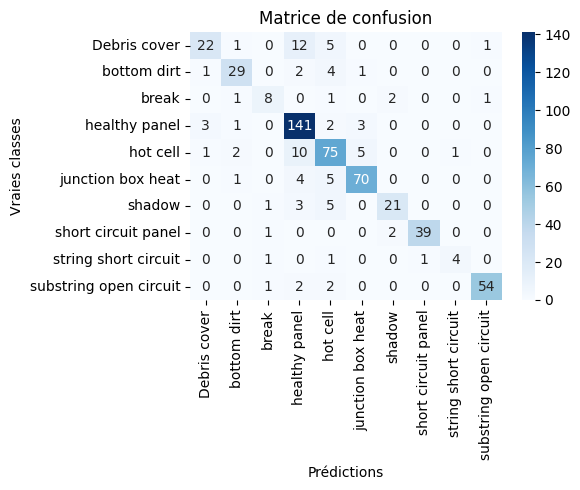

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.81      0.54      0.65        41
           bottom dirt       0.83      0.78      0.81        37
                 break       0.67      0.62      0.64        13
         healthy panel       0.81      0.94      0.87       150
              hot cell       0.75      0.80      0.77        94
     junction box heat       0.89      0.88      0.88        80
                shadow       0.84      0.70      0.76        30
   short circuit panel       0.97      0.93      0.95        42
  string short circuit       0.80      0.57      0.67         7
substring open circuit       0.96      0.92      0.94        59

              accuracy                           0.84       553
             macro avg       0.83      0.77      0.79       553
          weighted avg       0.84      0.84      0.83       553



🏃 View run sedate-croc-735 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/555a7566fb3c4e599770806cb4e0dd5f
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost_ADASYN pour le split 90.10
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 122.21 secondes
Entraînement - Temps de fit: 2.39 secondes
Temps total d'entraînement (pre-processing + fit): 124.61 secondes


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy',
                                                 EntropyExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'),
                ('sampler', ADASYN(random_state=42)),
                ('model',
                 XGBClassifierWithLabelEncoding(cl...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 14.61 secondes
Prédiction - Temps de prédiction: 0.02 secondes
Temps total de prédiction (pre-processing + prediction): 14.63 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


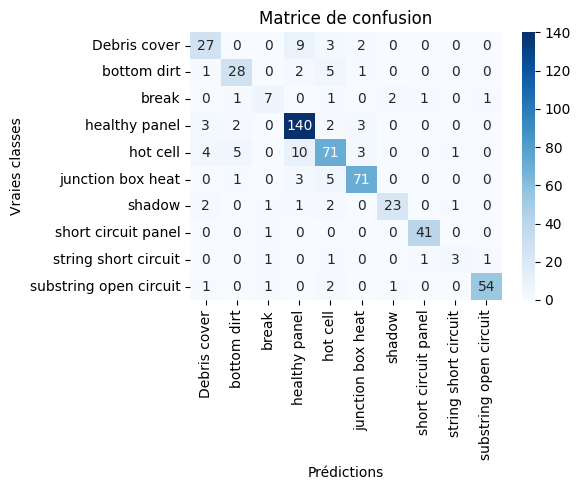

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.71      0.66      0.68        41
           bottom dirt       0.76      0.76      0.76        37
                 break       0.64      0.54      0.58        13
         healthy panel       0.85      0.93      0.89       150
              hot cell       0.77      0.76      0.76        94
     junction box heat       0.89      0.89      0.89        80
                shadow       0.88      0.77      0.82        30
   short circuit panel       0.95      0.98      0.96        42
  string short circuit       0.60      0.43      0.50         7
substring open circuit       0.96      0.92      0.94        59

              accuracy                           0.84       553
             macro avg       0.80      0.76      0.78       553
          weighted avg       0.84      0.84      0.84       553



🏃 View run righteous-shrimp-813 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/7a151cbd7f4d4b34a096abfd4fe88e95
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317

-----------------------------------------------------------------------------------------
Evaluation du meilleur pipeline basé sur XGBoost_noSampling pour le split 90.10
-----------------------------------------------------------------------------------------

Entraînement - Temps de pre-processing: 123.62 secondes
Entraînement - Temps de fit: 1.61 secondes
Temps total d'entraînement (pre-processing + fit): 125.23 secondes


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stats', BaseStatsExtractor()),
                                                ('glcm', GLCMExtractor()),
                                                ('edgedensity',
                                                 EdgeDensityExtractor()),
                                                ('entropy',
                                                 EntropyExtractor())])),
                ('dropper', VarianceThreshold()), ('scaler', 'passthrough'),
                ('selector', 'passthrough'), ('sampler', 'passthrough'),
                ('model',
                 XGBClassifierWithLabelEncoding(classes_=arr...
       'entropy__hist_bin10', 'entropy__hist_bin11', 'entropy__hist_bin12',
       'entropy__hist_bin13', 'entropy__hist_bin14', 'entropy__hist_bin15',
       'entropy__hist_bin16', 'entropy__hist_bin17', 'entropy__hist_bin18',
       'entropy__hist_bin19', 'entropy__hist_bin20'],
      dtype='object'),
                                                learning_rate=0.3, max_depth=6,
                                                min_child_weight=1,
                                                n_estimators=100,
                                                n_features_in_=76,
                                                random_state=42, subsample=1.0,
                                                tree_method='auto'))])

Prédiction - Temps de pre-processing: 15.91 secondes
Prédiction - Temps de prédiction: 0.01 secondes
Temps total de prédiction (pre-processing + prediction): 15.92 secondes

-------------------------------------------------------
Résultats obtenus sur le jeu de test du split 90.10 :


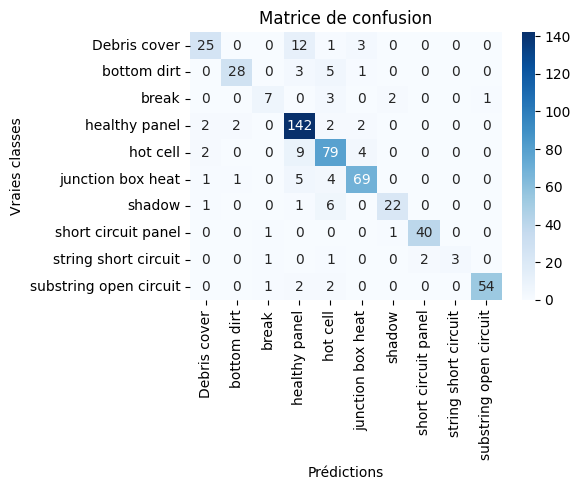

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.81      0.61      0.69        41
           bottom dirt       0.90      0.76      0.82        37
                 break       0.70      0.54      0.61        13
         healthy panel       0.82      0.95      0.88       150
              hot cell       0.77      0.84      0.80        94
     junction box heat       0.87      0.86      0.87        80
                shadow       0.88      0.73      0.80        30
   short circuit panel       0.95      0.95      0.95        42
  string short circuit       1.00      0.43      0.60         7
substring open circuit       0.98      0.92      0.95        59

              accuracy                           0.85       553
             macro avg       0.87      0.76      0.80       553
          weighted avg       0.85      0.85      0.84       553



🏃 View run shivering-moose-540 at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317/runs/239921c8897545a2bf76a2ed231a3ff2
🧪 View experiment at: http://mlflow.philippemarechal.org:35000/#/experiments/971923166830133317


In [57]:
best_pipelines_results_90_10 = pd.DataFrame()

get_test_results(best_pipelines, best_pipelines_results_90_10, split_name="90.10")

In [58]:
best_pipelines_results_90_10 = best_pipelines_results_90_10.sort_values("test_f1_macro", ascending=False)
display(best_pipelines_results_90_10)

,dataset_split,test_accuracy,test_f1_macro,test_f1_weighted,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,train_preproc_time,train_fit_time,total_train_time,predict_preproc_time,predict_pred_time,total_pred_time,n_features_pre_selector,n_features_post_selector
XGBoost_noSampling,90.10,0.848101,0.797292,0.844949,0.758411,0.848101,0.868038,0.852252,123.615142,1.614951,125.230093,15.911931,0.005004,15.916935,76.0,76.0
XGBoost_RandomOversampler,90.10,0.837251,0.793734,0.834117,0.766388,0.837251,0.833576,0.839624,115.066686,2.066610,117.133296,12.699598,0.015670,12.715268,76.0,76.0
XGBoost_ADASYN,90.10,0.840868,0.778873,0.838652,0.761659,0.840868,0.801376,0.838876,122.213816,2.391443,124.605259,14.609776,0.016301,14.626077,76.0,76.0


In [59]:
# Définition des scores à afficher en fonction du temps
scores = {
    "test_accuracy": "Précision vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 90/10)",
    "test_f1_macro": "F1_macro vs Temps d'entraînement - Résultats du meilleur pipeline de chaque classifieur sur le jeu de test (split 90/10)",
}

display_best_pipelines_graphs(best_pipelines_results_90_10)

### Observations

Sur le split 90/10 de référence, on constate là aussi que le temps de préprocessing pour l'entraînement est plus élevé pour le pipeline **noSampling** que pour le pipeline **RandomOversampler**. La différence avec **ADASYN**, par contre, est moins marquée.

En termes de performances, par contre, sur ce split 90/10, les scores du pipeline **RandomOversampler** sont moins bons que ceux du **noSampling**, tant sur le f1_score macro (79,37% vs 79.73%) que sur l'accuracy (83,73% vs 84,81%).